Pet prediction using image processing. 
Uses a binary classification to check if the pet is a dog or a cat, whereby there are only two possible classifications. 

Imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


Getting the Dog and Cat dataset from kaggle.

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   124M      0  0:00:06  0:00:06 --:--:--  137M


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PetImages/Cat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ll
error:  invalid response [ll]
replace PetImages/Cat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
n
 kagglecatsanddogs_3367a.zip  'MSR-LA - 3467.docx'  'readme[1].txt'
 model.png		       PetImages	     sample_data


In [4]:
!ls PetImages

Cat  Dog


Filtering of Corrupt Images

In [5]:
import os

num_skipped = 0
for folder_name in ("Cat","Dog"):
  folder_path = os.path.join("PetImages", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_skipped += 1

      os.remove(fpath)

  print("Deleted %d images" % num_skipped)

      

Deleted 759 images
Deleted 1590 images


In [6]:
image_size = (180, 180)

batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset = "training",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset = "validation",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


Visualzing the data

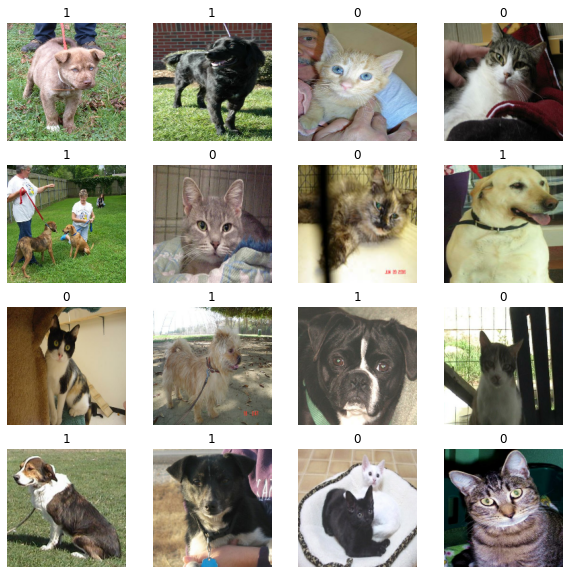

In [7]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  #Checking for the first 16 images with the value 1 representing dogs and 0 cats
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

Applying random transformations to expose the model to different aspects of training data.

In [8]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1)]
)

Visualizing the Augmented data

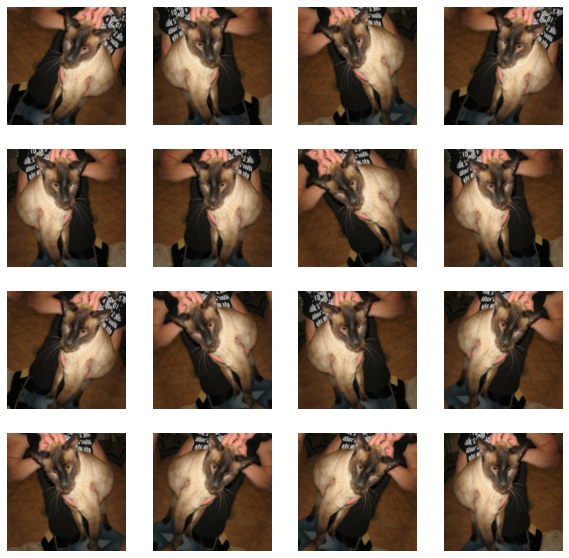

In [9]:
plt.figure(figsize = (10, 10))
for images, _ in train_ds.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Standardize the data

In [10]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Building the Model

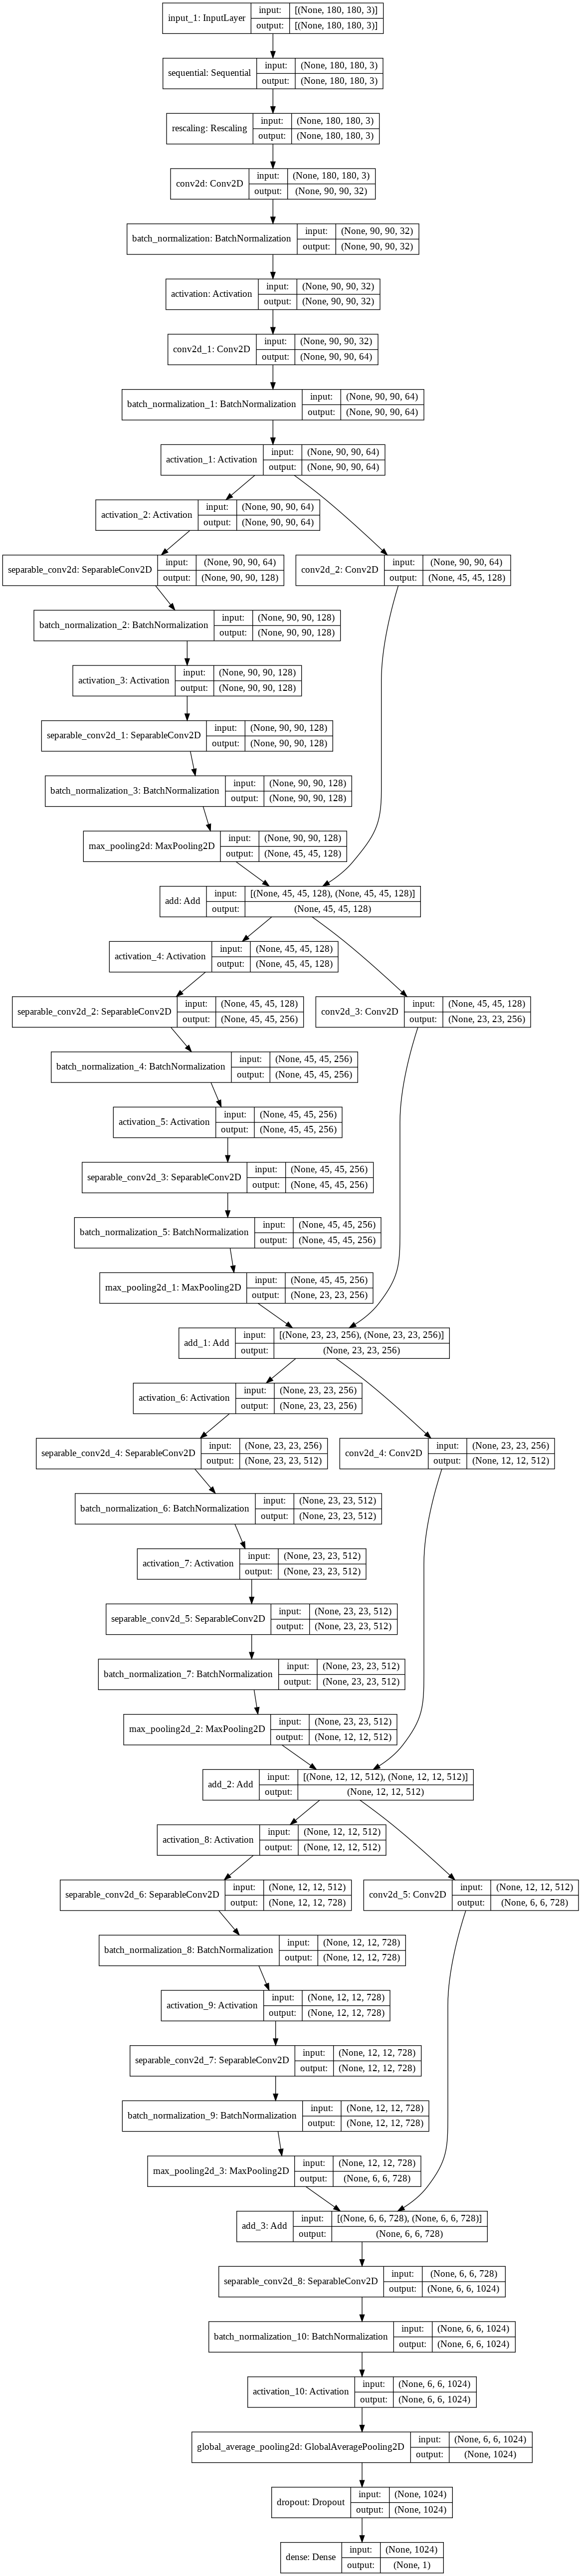

In [11]:
def make_model (input_shape, num_classes):
   inputs = keras.Input(shape = input_shape)

   x = data_augmentation(inputs)

   x = layers.Rescaling(1.0/255)(x)
   x = layers.Conv2D(32, 3, strides = 2, padding = "same")(x)
   x = layers.BatchNormalization()(x)
   x = layers.Activation("relu")(x)

   x = layers.Conv2D(64, 3, padding = "same")(x)
   x = layers.BatchNormalization()(x)
   x = layers.Activation("relu")(x)

   previous_block_activation = x

   for size in [128, 256, 512, 728]:
     x = layers.Activation("relu")(x)
     x = layers.SeparableConv2D(size, 3, padding="same")(x)
     x = layers.BatchNormalization()(x)

     x = layers.Activation("relu")(x)
     x = layers.SeparableConv2D(size, 3, padding = "same")(x)
     x = layers.BatchNormalization()(x)

     x = layers.MaxPooling2D(3, strides = 2, padding = "same")(x)

     residual = layers.Conv2D(size, 1, strides=2, padding = "same")(
        previous_block_activation
     )
     x = layers.add([x, residual])
     previous_block_activation = x

   x = layers.SeparableConv2D(1024, 3, padding="same")(x)
   x = layers.BatchNormalization()(x)
   x = layers.Activation("relu")(x)

   x = layers.GlobalAveragePooling2D()(x)
   if num_classes == 2:
     activation = "sigmoid"
     units = 1

   else:
     activation = "softmax"
     units = num_classes

   x = layers.Dropout(0.5)(x)
   outputs = layers.Dense(units, activation=activation)(x)
   return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes = 2)
keras.utils.plot_model(model, show_shapes=True)

Training the Model 

In [12]:
epochs = 10

callbacks = [
             keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "binary_crossentropy",
    metrics = ["accuracy"],
)
model.fit(
    train_ds, 
    epochs = epochs,
    callbacks = callbacks,
    validation_data = val_ds,
)

586/586 [==============================] - 5555s 9s/step - loss: 0.6305 - accuracy: 0.6619 - val_loss: 0.7598 - val_accuracy: 0.6155


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Checking with new data

In [13]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size = image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0]

print ("This image is %.2f percent cat and %.2f percent dog." % (100 * (1-score), 100 * score))

This image is 89.58 percent cat and 10.42 percent dog.
